In [1]:
%reload_ext autoreload
%autoreload 2

# import all the functions from the fastfeedback module
from fastfeedback import *

In [2]:
#Loading the CAFs data

data_manager = DataManager("~/atmospherics/caf_new_sum_weighted.root")

Loading data...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/awkward/_nplikes/array_module.py:515: RuntimeWarning: invalid value encountered in cast
  return self._module.concatenate(arrays, axis=axis, casting="same_kind")


Finished loading data


# I. Using the current reconstruction performance

In [3]:
#Preparing the data with the default settings, of the current reco performances
data = data_manager.prepare_data()

#Defining the binning for the true and reco energy and coszenith
Ebins = np.logspace(-1, 1, 200)
Czbins = np.linspace(-1, 1, 100)
Ebins_reco = np.logspace(-1, 1, 50)
Czbins_reco = np.linspace(-1, 1, 20)

#Creating the events distribution
events = EventDistrib(data, Ebins, Czbins, Ebins_reco, Czbins_reco)

Filling histograms...
Using the following detected output channels: ['NC', 'NuE', 'NuMu']
Finished filling histograms...


In [15]:
from tqdm import tqdm

null_hyps = [
    get_nufit(MH.Normal),
    get_nufit(MH.Normal),
    get_nufit(MH.Inverted),
    get_nufit(MH.Inverted)
    ]
null_hyps[0].dcp = 0
null_hyps[1].dcp = np.pi/2
null_hyps[2].dcp = 0
null_hyps[3].dcp = np.pi/2

ref_event_rates = []

for null_hyp in null_hyps:
    events.compute_osc(null_hyp)
    ref_event_rates.append({fl: events.detected_events(fl) for fl in events.detected_channels})

LnL_values_nofit = [[] for _ in range(len(null_hyps))]
dcp_scan = np.linspace(-np.pi, np.pi, 40)
for dcp in tqdm(dcp_scan):
    alt_hyp = get_nufit(MH.Normal)
    alt_hyp.dcp = dcp

    events.compute_osc(alt_hyp)

    expected = {fl: events.detected_events(fl) for fl in events.detected_channels}

    for i, null_hyp in enumerate(null_hyps):
        #Computing the LnL values
        llh = 0
        for ch in events.detected_channels:
            llh += LnL(ref_event_rates[i][ch], expected[ch])
        LnL_values_nofit[i].append(llh)




100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


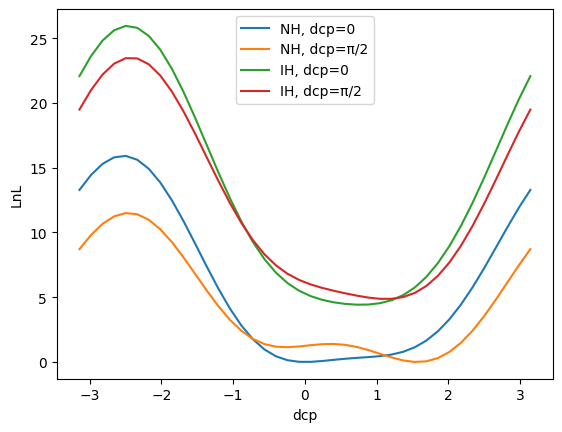

In [18]:
plt.plot(dcp_scan, LnL_values_nofit[0], label="NH, dcp=0")
plt.plot(dcp_scan, LnL_values_nofit[1], label="NH, dcp=π/2")
plt.plot(dcp_scan, LnL_values_nofit[2], label="IH, dcp=0")
plt.plot(dcp_scan, LnL_values_nofit[3], label="IH, dcp=π/2")

plt.xlabel("dcp")
plt.ylabel("LnL")
plt.legend()

In [14]:
from tqdm import tqdm

null_hyps = [
    get_nufit(MH.Normal),
    get_nufit(MH.Normal),
    get_nufit(MH.Inverted),
    get_nufit(MH.Inverted)
    ]
null_hyps[0].dcp = 0
null_hyps[1].dcp = np.pi/2
null_hyps[2].dcp = 0
null_hyps[3].dcp = np.pi/2

ref_event_rates = []


nuisance_params = ["th23"]

fitter = OscFit(events)

LnL_values = [[] for _ in range(len(null_hyps))]
dcp_scan = np.linspace(-np.pi, np.pi, 40)
for dcp in tqdm(dcp_scan):
    alt_hyp = get_nufit(MH.Normal)
    alt_hyp.dcp = dcp

    fit_result = fitter.fit(null_hyps[0], nuisance_params, alt_hyp)
    LnL_values[0].append(fit_result.fval)


100%|██████████| 40/40 [03:18<00:00,  4.96s/it]


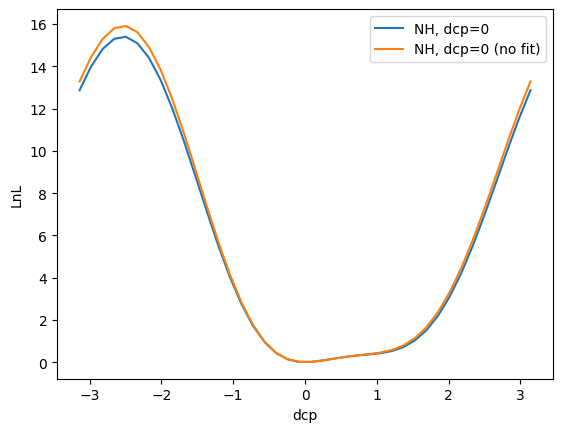

In [19]:
plt.plot(dcp_scan, LnL_values[0], label="NH, dcp=0")
plt.plot(dcp_scan, LnL_values_nofit[0], label="NH, dcp=0 (no fit)")

plt.xlabel("dcp")
plt.ylabel("LnL")
plt.legend()

In [ ]:
res.

<ErrorView dm21=7.499999999999999e-07 dm31=2.457e-05 th12=0.005839958715755919 th13=0.0014819001778459274 th23=0.007373241279447565 dcp=0.7384308371237487>

In [5]:
from tqdm import tqdm

#Gets the standard oscillation parameters
pars = get_nufit(MH.Normal)
#Compute the events with the standard oscillation parameters
events.compute_osc(pars)
#Saving the reference event rates
ref_event_rates = {fl: events.detected_events(fl) for fl in events.detected_channels}

LnL_values = {fl: [] for fl in events.detected_channels}

#Sampling dcp values
sampling = np.linspace(0, 2*np.pi, 50)
for val in tqdm(sampling):
    #Setting the dcp value
    pars.dcp = val
    #Computing the events with the new dcp value
    events.compute_osc(pars)
    #Saving the expected event rates
    expected = {fl: events.detected_events(fl) for fl in events.detected_channels}

    #Computing the LnL values
    for ch in events.detected_channels:
        LnL_values[ch].append(LnL(ref_event_rates[ch], expected[ch]))

#Converting the lists to numpy arrays
LnL_values = {fl: np.array(values) for fl, values in LnL_values.items()}

100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


In [30]:
def loss(dm21, dm31, th12, th13, th23, dcp):
    pars = ROOT.OscPars()
    pars.dm21 = dm21
    pars.dm31 = dm31
    pars.th12 = th12
    pars.th13 = th13
    pars.th23 = th23
    pars.dcp  = dcp
    
    events.compute_osc(pars)
    #Saving the expected event rates
    expected = {fl: events.detected_events(fl) for fl in events.detected_channels}
    total_loss = 0
    for ch in events.detected_channels:
        total_loss += LnL(ref_event_rates[ch], expected[ch])
    # print(total_loss)
    return total_loss

nufit = get_nufit(MH.Normal)

fitter = iminuit.Minuit(loss, dm21=nufit.dm21, dm31=nufit.dm31, th12=nufit.th12, th13=nufit.th13, th23=nufit.th23, dcp=nufit.dcp)

In [31]:
fitter.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.956e-13                  │              Nfcn = 78               │
│ EDM = 1.12e-16 (Goal: 0.0002)    │           time = 49.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ dm21 │  0.07e-3  │  0.08e-3  │            │            │         │         │       │
│ 1 │ dm31 │  2.46e-3  │  0.06e-3  │            │            │         │         │       │
│ 2 │ th12 │    0.6    │    0.5    │            │            │         │         │       │
│ 3 │ th13 │   0.15    │   0.05    │            │            │         │         │       │
│ 4 │ th23 │   0.737   │   0.034   │            │            │         │         │       │
│ 5 │ dcp  │    5.3    │    0.7    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────────────────────────────────────────────────────────────────────┐
│      │        dm21        dm31        th12        th13        th23         dcp │
├──────┼─────────────────────────────────────────────────────────────────────────┤
│ dm21 │    5.77e-09      3.0e-9    6.322e-6     -559e-9      411e-9   16.525e-6 │
│ dm31 │      3.0e-9    3.46e-09 -15.0508e-6   -687.0e-9    678.5e-9  22.9719e-6 │
│ th12 │    6.322e-6 -15.0508e-6       0.271      0.0031     -0.0065       -0.18 │
│ th13 │     -559e-9   -687.0e-9      0.0031      0.0027     -0.0001     -0.0128 │
│ th23 │      411e-9    678.5e-9     -0.0065     -0.0001     0.00112      0.0087 │
│  dcp │   16.525e-6  22.9719e-6       -0.18     -0.0128      0.0087       0.434 │
└──────┴─────────────────────────────────────────────────────────────────────────┘

In [32]:
fitter.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.956e-13                  │              Nfcn = 130              │
│ EDM = 2.19e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ dm21 │  0.07e-3  │  0.08e-3  │            │            │         │         │       │
│ 1 │ dm31 │  2.46e-3  │  0.06e-3  │            │            │         │         │       │
│ 2 │ th12 │    0.6    │    0.5    │            │            │         │         │       │
│ 3 │ th13 │   0.15    │   0.05    │            │            │         │         │       │
│ 4 │ th23 │   0.737   │   0.034   │            │            │         │         │       │
│ 5 │ dcp  │    5.3    │    0.7    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────────────────────────────────────────────────────────────────────┐
│      │        dm21        dm31        th12        th13        th23         dcp │
├──────┼─────────────────────────────────────────────────────────────────────────┤
│ dm21 │    5.79e-09      3.0e-9    6.292e-6     -577e-9      411e-9   16.684e-6 │
│ dm31 │      3.0e-9    3.47e-09 -15.0546e-6   -699.8e-9    681.3e-9  23.1023e-6 │
│ th12 │    6.292e-6 -15.0546e-6       0.271      0.0032     -0.0065       -0.18 │
│ th13 │     -577e-9   -699.8e-9      0.0032     0.00271     -0.0001     -0.0130 │
│ th23 │      411e-9    681.3e-9     -0.0065     -0.0001     0.00112      0.0088 │
│  dcp │   16.684e-6  23.1023e-6       -0.18     -0.0130      0.0088       0.436 │
└──────┴─────────────────────────────────────────────────────────────────────────┘

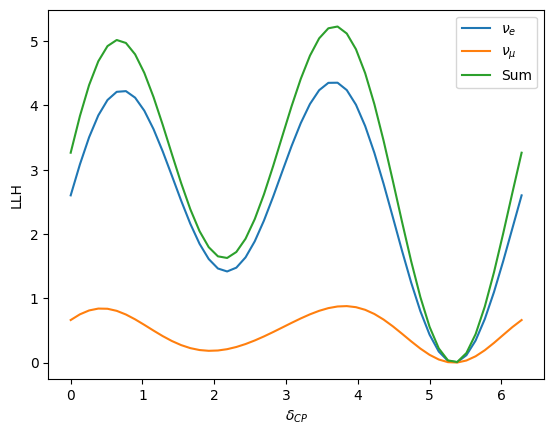

In [6]:
latex_names = {
    Flavor.NuE: r"$\nu_e$",
    Flavor.NuMu: r"$\nu_\mu$",
    Flavor.NuMuBar: r"$\bar{\nu}_\mu$",
    Flavor.NuEBar: r"$\bar{\nu}_e$",
    Flavor.NuTau: r"$\bar{\nu}_\tau$",
    Flavor.NuTauBar: r"$\bar{\nu}_\tau$",
}


plt.figure()
sum = 0
for ch, values in LnL_values.items():
    if ch == Flavor.NC:
        continue
    sum += values
    plt.plot(sampling, values, label=latex_names[ch])
plt.plot(sampling, sum, label="Sum")
plt.xlabel(r'$\delta_{CP}$')
plt.ylabel('LLH')
plt.legend()

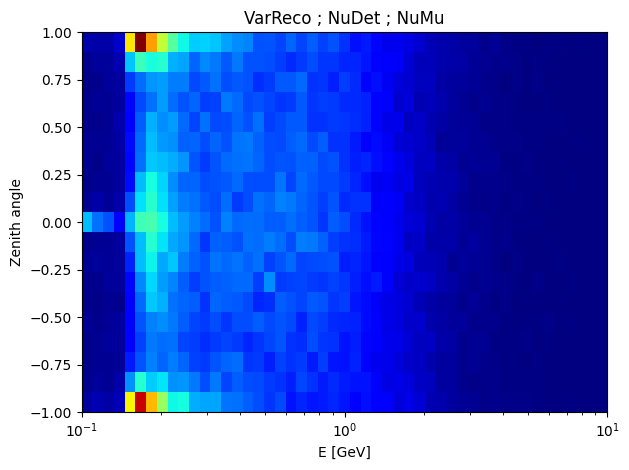

In [20]:
#Plotting some event distributions
pars = get_nufit(MH.Normal)
events.compute_osc(pars)
fig = events.plot_distrib(VarType.VarReco, NuAxis.NuDet, Flavor.NuMu, oscillated=True)

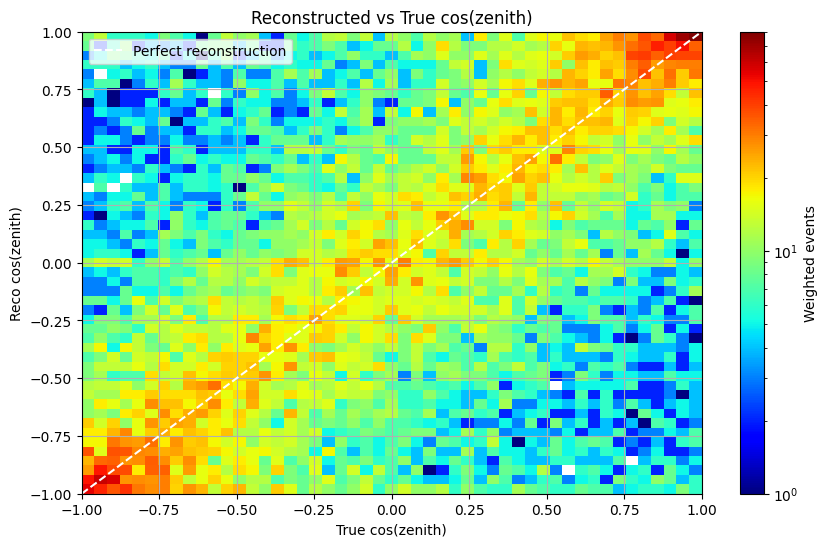

In [27]:
def reco_dir_plot(data):
    plt.figure(figsize=(10, 6))
    cc = data.filter(
        pl.col('isCC'),
        pl.col('reco_pdg') == 14
    )
    plt.hist2d(cc['direc_true'], cc['direc_reco'], bins=np.linspace(-1, 1, 50), cmap='jet', norm='log')
    plt.colorbar(label='Weighted events')
    plt.plot([-1, 1], [-1, 1], color='white', linestyle='--', label='Perfect reconstruction')
    plt.xlabel('True cos(zenith)')
    plt.ylabel('Reco cos(zenith)')
    plt.title('Reconstructed vs True cos(zenith)')
    plt.legend()
    plt.grid()
    plt.show()

reco_dir_plot(data)

/var/folders/_d/sfp1ctxj3g13373lj9lb38q80000gn/T/ipykernel_14094/1176349466.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('count'),
/var/folders/_d/sfp1ctxj3g13373lj9lb38q80000gn/T/ipykernel_14094/1176349466.py:12: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  matrix = groups.pivot(


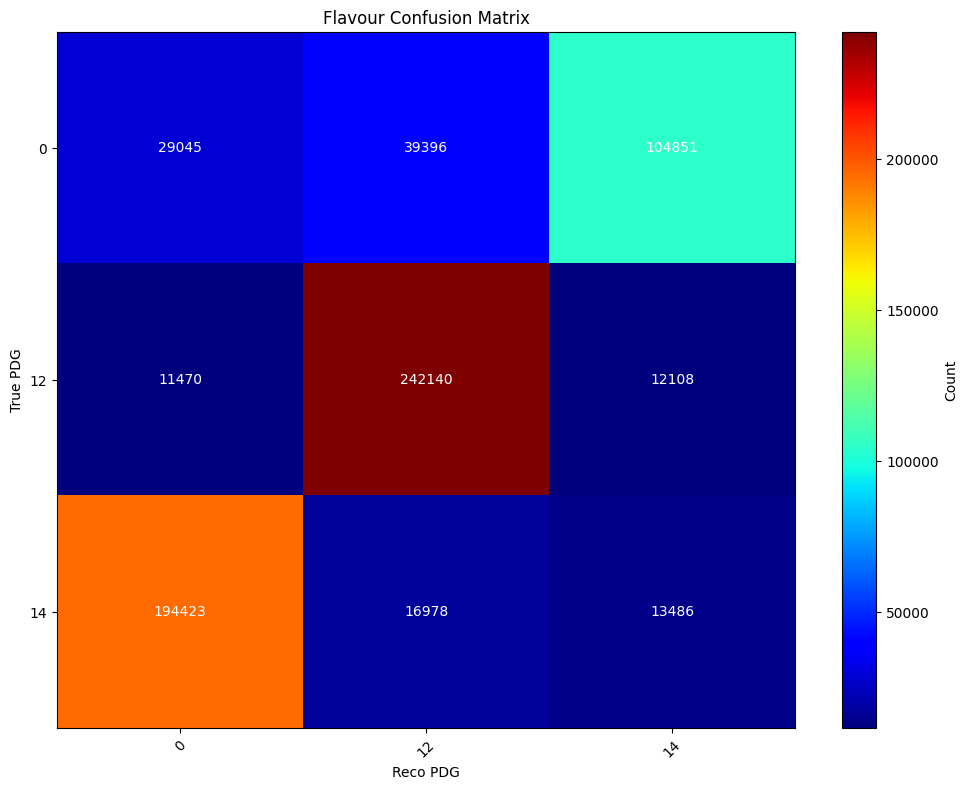

In [32]:
def flavour_confusion_matrix(events):
    df = events.with_columns(
        true_pdg=pl.col('nuPDG').abs() * pl.col('isCC'),
    ).filter(
        pl.col('true_pdg').abs() != 16
    )

    groups = df.group_by(['true_pdg', 'reco_pdg']).agg(
        pl.count().alias('count'),
    ).sort('true_pdg')

    matrix = groups.pivot(
        index='true_pdg',
        columns='reco_pdg',
        values='count',
        aggregate_function='sum',
    ).fill_null(0).sort('true_pdg')

    return matrix

matrix = flavour_confusion_matrix(data)
plt.figure(figsize=(10, 8))
plt.imshow(matrix.to_numpy()[:, 1:], cmap='jet', aspect='auto')

#Also write values on the matrix
for i in range(len(matrix['true_pdg'])):
    for j in range(1, len(matrix.columns)):
        plt.text(j-1, i, int(matrix.to_numpy()[i, j]), ha='center', va='center', color='white')

plt.colorbar(label='Count')
plt.xticks(ticks=np.arange(len(matrix.columns)-1), labels=matrix.columns[1:], rotation=45)
plt.yticks(ticks=np.arange(len(matrix['true_pdg'])), labels=matrix['true_pdg'])
plt.xlabel('Reco PDG')
plt.ylabel('True PDG')
plt.title('Flavour Confusion Matrix')
plt.tight_layout()

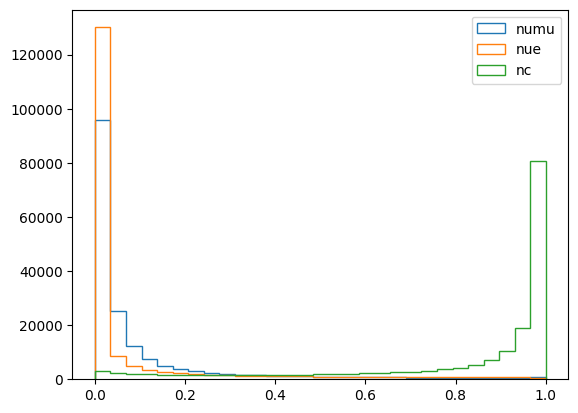

In [44]:
numu = data.filter(
    pl.col('nuPDG') == 14,
    pl.col('isCC')
)
plt.hist(numu['cvn_numu'], bins=np.linspace(0, 1, 30), histtype='step', label='numu');
plt.hist(numu['cvn_nue'], bins=np.linspace(0, 1, 30), histtype='step', label='nue');
plt.hist(numu['cvn_nc'], bins=np.linspace(0, 1, 30), histtype='step', label='nc');
plt.legend()

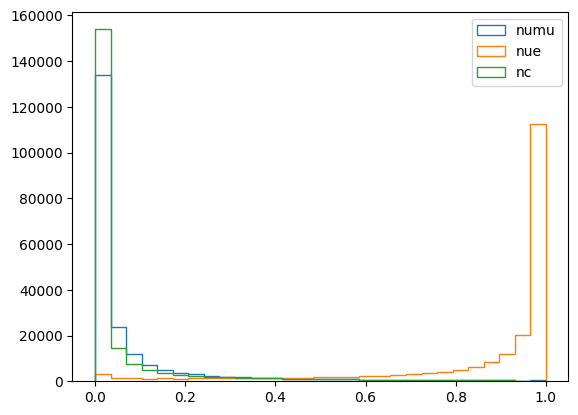

In [45]:
numu = data.filter(
    pl.col('nuPDG') == 12,
    pl.col('isCC')
)
plt.hist(numu['cvn_numu'], bins=np.linspace(0, 1, 30), histtype='step', label='numu');
plt.hist(numu['cvn_nue'], bins=np.linspace(0, 1, 30), histtype='step', label='nue');
plt.hist(numu['cvn_nc'], bins=np.linspace(0, 1, 30), histtype='step', label='nc');
plt.legend()

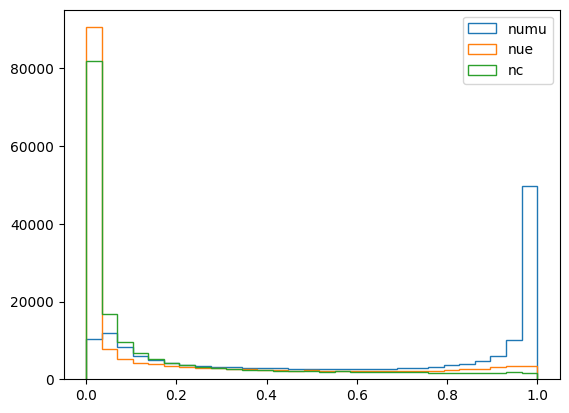

In [47]:
nc = data.filter(
    ~pl.col('isCC')
)
plt.hist(nc['cvn_numu'], bins=np.linspace(0, 1, 30), histtype='step', label='numu');
plt.hist(nc['cvn_nue'], bins=np.linspace(0, 1, 30), histtype='step', label='nue');
plt.hist(nc['cvn_nc'], bins=np.linspace(0, 1, 30), histtype='step', label='nc');
plt.legend()

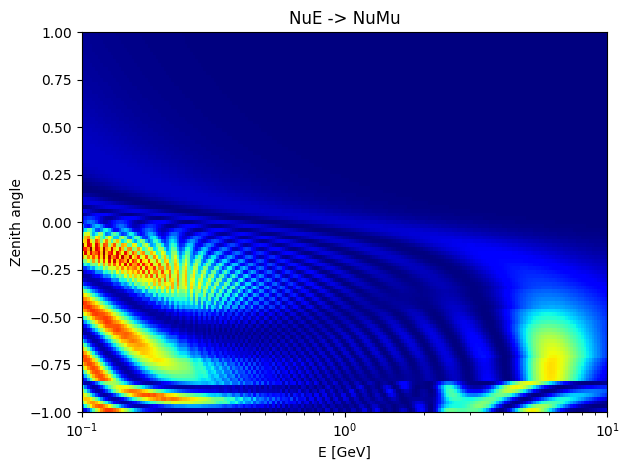

In [12]:
#Plotting some oscillograms
fig = events.get_oscillogram(Flavor.NuE, Flavor.NuMu)

# II. Tweaking some resolutions by hand

### What happens to the dCP sensitivity if we can make some nu/nubar separation?

In [8]:
data_manager.set_direc_reco(Method.Reco)
data_manager.set_energy_reco(Method.Reco)
data_manager.set_flavor_discrimination(Method.Reco)

efficiencies = {
    Flavor.NuE: 1,
    Flavor.NuEBar: 1,
    Flavor.NuMu: 1,
    Flavor.NuMuBar: 1,
}
nunubar = FakeEfficiency(efficiencies)
data_manager.set_nunubar_discrimination(Method.Efficiency, nunubar)
data = data_manager.prepare_data()
events = EventDistrib(data, Ebins, Czbins, Ebins_reco, Czbins_reco)

Filling histograms...
Using the following detected output channels: ['NuMuBar', 'NuEBar', 'NC', 'NuE', 'NuMu']
Finished filling histograms...


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]


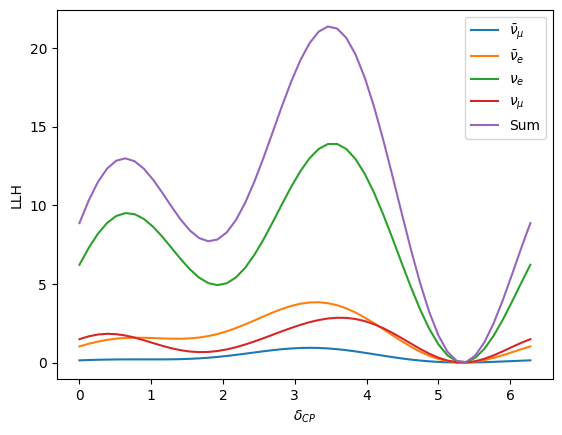

In [10]:
#Updated sensitivity

#Gets the standard oscillation parameters
pars = get_nufit(MH.Normal)
#Compute the events with the standard oscillation parameters
events.compute_osc(pars)
#Saving the reference event rates
ref_event_rates = {fl: events.detected_events(fl) for fl in events.detected_channels}

LnL_values = {fl: [] for fl in events.detected_channels}

#Sampling dcp values
sampling = np.linspace(0, 2*np.pi, 50)
for val in tqdm(sampling):
    #Setting the dcp value
    pars.dcp = val
    #Computing the events with the new dcp value
    events.compute_osc(pars)
    #Saving the expected event rates
    expected = {fl: events.detected_events(fl) for fl in events.detected_channels}

    #Computing the LnL values
    for ch in events.detected_channels:
        LnL_values[ch].append(LnL(ref_event_rates[ch], expected[ch]))

#Converting the lists to numpy arrays
LnL_values = {fl: np.array(values) for fl, values in LnL_values.items()}

plt.figure()
sum = 0
for ch, values in LnL_values.items():
    if ch == Flavor.NC:
        continue
    sum += values
    plt.plot(sampling, values, label=latex_names[ch])
plt.plot(sampling, sum, label="Sum")
plt.xlabel(r'$\delta_{CP}$')
plt.ylabel('LLH')
plt.legend()

**We can see some sensitivity improvement**

In [ ]:
data_manager.set_direc_reco(Method.Reco)
data_manager.set_energy_reco(Method.Reco)
data_manager.set_flavor_discrimination(Method.Reco)
data_manager.set_nunubar_discrimination(Method.Reco)

#Adding some fake resolution for the energy (can also be done for the direction)
Ebins_fake = np.logspace(-1, 1, 100)
Eres = np.ones(len(Ebins_fake)+1)*0.1
Efake = FakeResolution(Ebins_fake, Eres, pl.col('Ev'))
data_manager.set_energy_reco(Method.Efficiency, Efake)

data = data_manager.prepare_data()
events = EventDistrib(data, Ebins, Czbins, Ebins_reco, Czbins_reco)

#To be continued...